# Notebook 3: Proposition de mots clés – Approche non supervisée

## 1. Libraries

In [18]:
import numpy as np
import pandas as pd
import re
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.lda_model
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# style for all plots
sns.set_style("darkgrid")
sns.set_palette("vlag")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2})
sns.set(rc={
    'axes.labelsize': 10,      
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
    'axes.labelcolor': 'gray', 
    'xtick.color': 'gray', 
    'ytick.color': 'gray',
    'axes.titlesize': 12,    
})

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore", category=UserWarning, message=".*token_pattern.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*looks more like a filename.*")


## 2. Load data

In [2]:
# Load Data
df = pd.read_csv("QueryResults2.csv")

# Drop unnecessary columns
df.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount'], inplace=True) #, 'FavoriteCount'
#df = df.sample(frac=0.2, random_state=42)
#df.reset_index(drop=True, inplace=True)

## 3. Preprocessing

In [3]:
# Function for cleaning TAGS ---------------------------------------------------------------------
special_words = {'c#', 'c++', 'f#', 'asp.net', 'vb.net', 'node.js', 'objective-c', 'ai'}

# Function for the 'Tags' colum ---------------------------------------------------------------------
def preprocess_tags(tags):
    def clean_word(word):        
        if word in special_words: # Preserve special words exactly
            return word        
        cleaned_word = re.sub(r"[^\w\s\-]", "", word) # Remove unwanted characters except hyphen, apostrophe        
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        if re.search(r"\d", cleaned_word):  # Remove words containing any number
            return ""
        return cleaned_word    
        
    words = re.findall(r'(?<=<)(.*?)(?=>)', tags)  # Extract words
    processed_words = [
        clean_word(word) for word in words] # Keep words within length constraints 
    words = [subword for word in processed_words for subword in word.split()]  
    words = [w for w in words if len(w) > 2 or w in special_words] 
    return words

# Function for cleaning BODY & TITLE ---------------------------------------------------------------------
def clean_text(sentence):
    def clean_word(word):
        if word in special_words: # Preserve special words exactly
            return [word]
        cleaned_word = re.sub(r"(\'s|\'ve|\'d|\'ll|\'re|\'m|\'t)$", "", word) # Remove common contraction suffixes
        cleaned_word = re.sub(r"[^\w\s\-]", " ", cleaned_word) # Replace non-alphanumeric characters (except hyphens) with spaces
        cleaned_word = re.sub(r"^-+", "", cleaned_word) # Remove leading hyphens
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        cleaned_word = cleaned_word.strip() # Trim whitespace
        
        if len(cleaned_word) < 3 and cleaned_word not in special_words: # Remove words with length < 3 unless in special_words
            return None
        
        split_words = re.split(r'[.\-#]', cleaned_word) # Split words like 'this.opacity' into 'this' and 'opacity'
        split_words = [sub_word for word in split_words for sub_word in word.split() if sub_word] # Additional split on spaces and remove empty strings
        return [w for w in split_words if w]
        
    soup = BeautifulSoup(sentence, "html.parser") # Remove HTML tags and convert to lowercase
    sentence = soup.get_text()
    sentence = sentence.lower()
    words = re.findall(r"\w+[-.#']?\w*|\S+", sentence)
    processed_words = [clean_word(word) for word in words]
    filtered_words = [
        word for sublist in processed_words if sublist for word in sublist
        if (word in special_words or len(word) > 2)  # Preserve special words or words with length > 2
        and '_' not in word  # Exclude words with underscores
        and word.isascii()  # Exclude non-ASCII words
        and not any(char.isdigit() for char in word)]  # Exclude words with digits
    return filtered_words
    
# STOP WORDS -------------------------------------------------------------------
stop_w = set(stopwords.words('english'))
def stop_word_filter(list_words):
    return [ w for w in list_words if w not in stop_w]

# LEMMA -------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
def lemma_words(list_words):
    return [lemmatizer.lemmatize(w, pos='v') for w in list_words]

# Remove specific words -------------------------------------------------------------------
words_to_exclude = {'however', 'good', 'use', 'anyone', 'say', 'problem','better', 'another', 'please', 'etc', 'actually','someone', 'happen', 'ask',  'maybe', 'look', 'little', 'advance',
'need', 'something', 'question', 'example', 'thank', 'also', 'cannot', 'think', 'anything', 'idea', 'thing', 'ideas', 'people', 'basically', 'nice', 'easily', 'feel',
'obviously', 'specifically', 'problem'}
#def remove_words(tokens):
#    tagged_tokens = nltk.pos_tag(tokens)
#    tags_to_remove = {'MD', 'CD' } # 'WRB', 'WP$', 'PRP$', 'PDT', 'JJR',  'EX'
#    return [ word for word, tag in tagged_tokens
#        if tag not in tags_to_remove and word.lower() not in words_to_exclude]
def remove_words(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
    return [word for word, tag in tagged_tokens if tag in noun_tags and word.lower() not in words_to_exclude]

# Preprocessing BODY & TITLE ---------------------------------------------------------------------
def custom_tokenizer(desc_text):
    cleaned = clean_text(desc_text)
    filtered = stop_word_filter(cleaned)
    lemmatized = lemma_words(filtered)
    words_removed = remove_words(lemmatized)
    return words_removed
    
# Apply preprocessing
df['Tags'] = df['Tags'].apply(preprocess_tags)
df['title_clean_bow'] = df['Title'].apply(custom_tokenizer)
df['body_clean_bow'] = df['Body'].apply(custom_tokenizer)

# Combine "Title" and "Body" for the Bag of Words approach
df['combined_text_bow'] = df['title_clean_bow'] + df['body_clean_bow']
df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: ' '.join(x))
X = df['combined_text_bow']
y = df['Tags']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# # Vectorize
cv = CountVectorizer(tokenizer=custom_tokenizer,  max_features=5000,  min_df=10, max_df=0.9, ngram_range=(1, 2), stop_words=None, lowercase=False)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

features_names_cv = cv.get_feature_names_out()

print('Vocabulary size:', len(cv.vocabulary_))
print("Shape of X_train_cv:", X_train_cv.shape)
print("Shape of X_test_cv:", X_test_cv.shape)

Vocabulary size: 3485
Shape of X_train_cv: (8000, 3485)
Shape of X_test_cv: (2000, 3485)


## 4. Optimisation du nombre de topics

### 4.1 Perplexité

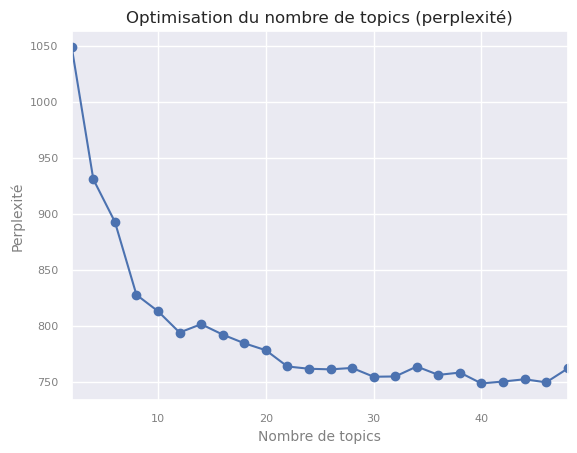

In [21]:
# Liste des valeurs de n_components à tester
n_topics_range = list(range(2, 50, 2))
perplexities = []

for n_topics in n_topics_range:
    lda = LDA(n_components=n_topics, random_state=0)
    lda.fit(X_train_cv)
    perplexities.append(lda.perplexity(X_train_cv))

plt.plot(n_topics_range, perplexities, marker='o')
plt.xlim(min(n_topics_range), max(n_topics_range))
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité")
plt.title("Optimisation du nombre de topics (perplexité)")
plt.show()

### 4.2 Coherence score

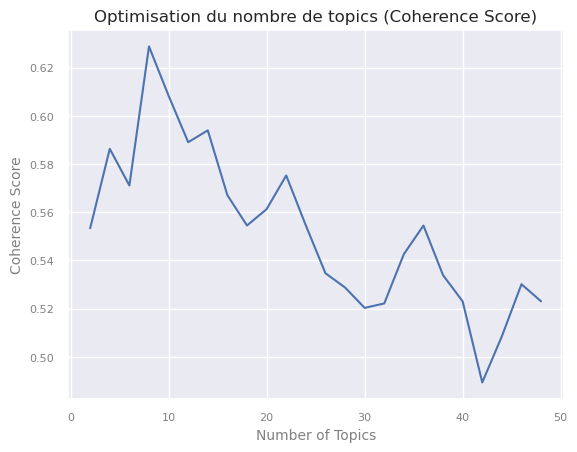

Best number of topics: 8


In [20]:
# Preprocess X_train to tokenize the text 
tokenized_texts = [doc.split() for doc in X_train] 

# Create Gensim dictionary 
dictionary = Dictionary(tokenized_texts)
#corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# LDA coherence score calculation
def compute_coherence_values(X_train_cv, feature_names, tokenized_texts, dictionary, start, limit, step):
    coherence_values = []
    models = []
    for n_topics in range(start, limit, step):
        # Train LDA model on CountVectorizer-transformed data
        lda_model = LDA(n_components=n_topics, random_state=42)
        lda_model.fit(X_train_cv)
        models.append(lda_model)

        # Extract topics and their top words
        topics = lda_model.components_
        topics_words = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in topics]

        # Compute coherence score using Gensim
        coherence_model = CoherenceModel(
            topics=topics_words, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        #print(f"Number of Topics: {n_topics}, Coherence Score: {coherence_score}")
        #print("Sample Topic Words:", topics_words[:3])  # Display sample topics

    return models, coherence_values

start = 2
limit = 50
step = 2

# Compute coherence scores
models, coherence_values = compute_coherence_values(
    X_train_cv=X_train_cv,  # Data after CountVectorizer
    feature_names=features_names_cv,  # Feature names from CountVectorizer
    tokenized_texts=tokenized_texts,  # Data before CountVectorizer (tokenized text)
    dictionary=dictionary,  # Gensim dictionary from tokenized text
    start=start, 
    limit=limit, 
    step=step
)

# Plot
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimisation du nombre de topics (Coherence Score)")
plt.show()

# Best number of topics
best_num_topics = x[np.argmax(coherence_values)]
print(f"Best number of topics: {best_num_topics}")


## 5. LDA Model

In [7]:
lda = LDA(n_components=10, random_state=42, learning_decay= 0.9) 
lda.fit(X_train_cv)
X_train_lda = lda.transform(X_train_cv)
X_test_lda = lda.transform(X_test_cv)

In [8]:
# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n--- Topic {topic_idx + 1} ---")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, features_names_cv, 10)


--- Topic 1 ---
class, type, model, method, methods, instance, name, bar, function, code

--- Topic 2 ---
code, application, test, program, time, work, memory, project, way, process

--- Topic 3 ---
java, system, error, org, apache, exception, java org, lang, java lang, org apache

--- Topic 4 ---
int, function, list, return, time, value, char, array, const, sort

--- Topic 5 ---
name, property, version, xml, value, org, http, hibernate, springframework, spring

--- Topic 6 ---
function, div, style, color, jquery, text, name, input, javascript, css

--- Topic 7 ---
image, page, view, call, work, way, request, client, site, form

--- Topic 8 ---
data, value, database, number, way, date, store, time, query, sql

--- Topic 9 ---
file, line, command, character, way, word, path, html, name, directory

--- Topic 10 ---
script, php, code, work, output, error, data, com, type, http


## 6. Visualisation des topics

In [9]:
pyLDAvis.enable_notebook()

# Prepare the data for visualization
lda_vis_data = pyLDAvis.lda_model.prepare(
    lda,                  # fitted LDA model
    X_train_cv,          # document-term matrix
    vectorizer=cv,       # CountVectorizer instance
    mds='tsne'           # t-SNE for dimensionality reduction
)
pyLDAvis.display(lda_vis_data)

## 7. Evaluation

### 7.1 Perplexity score

In [10]:
train_perplexity = lda.perplexity(X_train_cv)
print(f"Perplexité sur les données d'entraînement : {train_perplexity}")
test_perplexity = lda.perplexity(X_test_cv)
print(f"Perplexité sur les données de test : {test_perplexity}")

Perplexité sur les données d'entraînement : 812.1325055187898
Perplexité sur les données de test : 1354.74177131112


### 7.2 Coherence score

In [11]:
# Obtenir les mots les plus probables pour chaque topic
top_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words.append([features_names_cv[i] for i in topic.argsort()[:-10 - 1:-1]]) 

# Calculer la cohérence
coherence_model = CoherenceModel(topics=top_words, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score : {coherence_score}")

Coherence Score : 0.6083909196655293


### 7.3 Evaluation métier - Taux de couverture

In [12]:
# Calcul des probabilités de topics pour chaque observation // probabilités d'appartenance de chaque question aux topics
topic_probabilities_train = lda.transform(X_train_cv)
topic_probabilities_test = lda.transform(X_test_cv)

# Associe chaque observation au topic dominant (celui avec la probabilité la plus élevée)
dominant_topic_train = np.argmax(topic_probabilities_train, axis=1)
dominant_topic_test = np.argmax(topic_probabilities_test, axis=1)

# Affichez les principaux mots de chaque topic
def display_topics(model, feature_names, no_top_words=10):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_words

# apply function
topic_words = display_topics(lda, features_names_cv, 20)

# df
results_train = pd.DataFrame({
    'Original Document': tokenized_texts,  # Texte original de chaque observation
    'Dominant_Topic': dominant_topic_train,
    'Topic_Words': [topic_words[topic] for topic in dominant_topic_train],
    'Topic_Probabilities': [topic_probabilities_train[i] for i in range(X_train_cv.shape[0])]
})
results_train.head(1)


,Original Document,Dominant_Topic,Topic_Words,Topic_Probabilities
0,"[click, uialertview, crash, app, view, dismiss, display, error, view, uialertview, call, dismiss, therefore, release, user, click, app, crash, message, release, instance, send, cause, app, crash, uialertview, alertview, alloc, test, message, test, delegate, self, otherbuttontitles, show, alertview, release, alertview, unit, way, crash, view]",1,"[code, application, test, program, time, work, memory, project, way, process, system, source, language, machine, tool, message, solution, studio, development, edit]","[0.0031262098696746084, 0.5005641015959658, 0.003125864759409898, 0.0031251771045772226, 0.0031254525029344657, 0.003125371426722981, 0.47443137907592714, 0.0031251838254197748, 0.0031251909864909297, 0.0031260688528770893]"


In [13]:
results_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

results_train['Y_train_Tags'] = y_train

# Function to calculate coverage 
def calculate_coverage(row):
    topic_words = row['Topic_Words']
    y_tags = row['Y_train_Tags']       
    topic_set = set(topic_words) # Convert topic words to set 
    tags_set = set(y_tags)    
    common_words = topic_set.intersection(tags_set) # Find common words
    coverage_rate = len(common_words) / len(topic_set) if len(topic_set) > 0 else 0
    return len(common_words), coverage_rate

results_train[['Common_Words', 'Coverage_Rate']] = results_train.apply(calculate_coverage, axis=1, result_type='expand')
results_train[['Original Document', 'Dominant_Topic', 'Topic_Words', 'Common_Words', 'Coverage_Rate', 'Y_train_Tags']].head(5)


,Original Document,Dominant_Topic,Topic_Words,Common_Words,Coverage_Rate,Y_train_Tags
0,"[click, uialertview, crash, app, view, dismiss, display, error, view, uialertview, call, dismiss, therefore, release, user, click, app, crash, message, release, instance, send, cause, app, crash, uialertview, alertview, alloc, test, message, test, delegate, self, otherbuttontitles, show, alertview, release, alertview, unit, way, crash, view]",1,"[code, application, test, program, time, work, memory, project, way, process, system, source, language, machine, tool, message, solution, studio, development, edit]",0.0,0.00,"[iphone, cocoa-touch, uiviewcontroller, uialertview, dismiss]"
1,"[solution, manage, database, migrations, rail, database, migration, management, system, trick, django, ship, database, migration, system, number, source, project, evolution, wonder, database, migration, management, solution, django, option, answer]",1,"[code, application, test, program, time, work, memory, project, way, process, system, source, language, machine, tool, message, solution, studio, development, edit]",0.0,0.00,"[python, database, django, data-migration, schema-migration]"
2,"[browser, cache, css, file, regard, css, browser, try, search, post, nothing, css, file, web, project, reference, head, page, page, css, cache, download, request, hope, firefox, safari, css, refresh, browser, instance]",6,"[image, page, view, call, work, way, request, client, site, form, stack, button, load, server, post, service, application, asp.net, control, jquery]",0.0,0.00,"[html, css, http, caching, browser]"
3,"[postgres, order, time, php, script, bash, command, test, case, postgresql, database, create, modify, store, database, dump, regression, step, database, dump, compare, database, step, number, database, way, things, order, time, database, dump, comparison, result, file, order, way]",7,"[data, value, database, number, way, date, store, time, query, sql, field, point, array, result, row, column, float, record, order, server]",1.0,0.05,"[php, database, linux, postgresql, dump]"
4,"[error, java, lang, nosuchmethoderror, asm, classwriter, spring, application, store, detail, student, information, database, simpleformcontroller, netbeans, spring, deploy, project, errors, spring, config, xml, version, encode, spring, dtd, http, www, springframework, org, dtd, spring, bean, dtd, hibernate, session, factory, datasource, class, org, springframework, jdbc, datasource, drivermanagerdatasource, constructor, arg, index, value, driverclassname, value, constructor, constructor, arg, index, value, value, constructor, constructor, arg, index, value, value, constructor, constructor, arg, index, value, password, value, constructor, sessionfactory, class, org, springframework, property, name, datasource, ref, datasource, property, property, name, configlocation, value, class, hibernate, cfg, xml, value, property, property, name, mappingresources, value, hibernate, cfg, xml, value, list, property, ...]",2,"[java, system, error, org, apache, exception, java org, lang, java lang, org apache, method, lock, eclipse, core, import, source, catalina, com, sun, jar]",1.0,0.05,"[java, spring, hibernate, orm, java-bytecode-asm]"


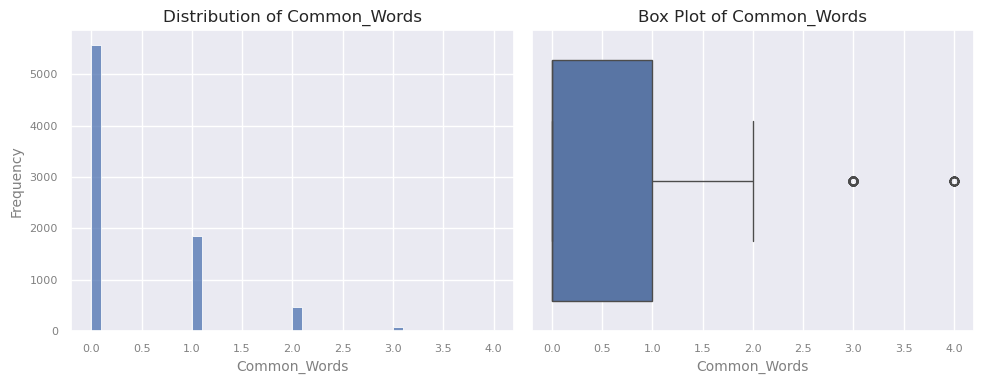

In [19]:
plt.figure(figsize=(10, 4))

# bar plot
plt.subplot(1, 2, 1) 
sns.histplot(results_train['Common_Words'])
plt.title('Distribution of Common_Words')
plt.xlabel('Common_Words')
plt.ylabel('Frequency')

# box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=results_train['Common_Words'])
plt.title('Box Plot of Common_Words')
plt.xlabel('Common_Words')
plt.tight_layout()
plt.show()